In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import scipy as sp
import scipy.interpolate
import scipy.ndimage
from scipy.io import readsav
import vicar
#!pip install rms_vicar

In [2]:
def congrid(a, newdims, method='linear', centre=False, minusone=False):
    '''Arbitrary resampling of source array to new dimension sizes.
    Currently only supports maintaining the same number of dimensions.
    To use 1-D arrays, first promote them to shape (x,1).
    
    Uses the same parameters and creates the same co-ordinate lookup points
    as IDL''s congrid routine, which apparently originally came from a VAX/VMS
    routine of the same name.

    method:
    neighbour - closest value from original data
    nearest and linear - uses n x 1-D interpolations using
                         scipy.interpolate.interp1d
    (see Numerical Recipes for validity of use of n 1-D interpolations)
    spline - uses ndimage.map_coordinates

    centre:
    True - interpolation points are at the centres of the bins
    False - points are at the front edge of the bin

    minusone:
    For example- inarray.shape = (i,j) & new dimensions = (x,y)
    False - inarray is resampled by factors of (i/x) * (j/y)
    True - inarray is resampled by(i-1)/(x-1) * (j-1)/(y-1)
    This prevents extrapolation one element beyond bounds of input array.
    '''
    if not a.dtype in [np.float64, np.float32]:
        a = np.asarray(a, dtype=float)

    m1 = np.asarray(minusone, dtype=int)
    ofs = np.asarray(centre, dtype=int) * 0.5
    old = np.array( a.shape )
    ndims = len( a.shape )
    if len( newdims ) != ndims:
        print ("[congrid] dimensions error. " \
              "This routine currently only support " \
              "rebinning to the same number of dimensions.")
        return None
    newdims = np.asarray( newdims, dtype=float )
    dimlist = []

    if method == 'neighbour':
        for i in range( ndims ):
            base = np.indices(newdims)[i]
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        cd = np.array( dimlist ).round().astype(int)
        newa = a[list( cd )]
        return newa

    elif method in ['nearest','linear']:
        # calculate new dims
        for i in range( ndims ):
            base = np.arange( newdims[i] )
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        # specify old dims
        olddims = [np.arange(i, dtype = float) for i in list( a.shape )]

        # first interpolation - for ndims = any
        mint = scipy.interpolate.interp1d( olddims[-1], a, kind=method, fill_value="extrapolate" )
        newa = mint( dimlist[-1] )

        trorder = [1,0] # = [ndims - 1] + range( ndims - 1 )
        for i in range( ndims - 2, -1, -1 ):
            newa = newa.transpose( trorder )

            mint = scipy.interpolate.interp1d( olddims[i], newa, kind=method, fill_value="extrapolate" )
            newa = mint( dimlist[i] )

        if ndims > 1:
            # need one more transpose to return to original dimensions
            newa = newa.transpose( trorder )

        return newa
    elif method in ['spline']:
        oslices = [ slice(0,j) for j in old ]
        oldcoords = np.ogrid[oslices]
        nslices = [ slice(0,j) for j in list(newdims) ]
        newcoords = np.mgrid[nslices]

        newcoords_dims = range(np.rank(newcoords))
        #make first index last
        newcoords_dims.append(newcoords_dims.pop(0))
        newcoords_tr = newcoords.transpose(newcoords_dims)
        # makes a view that affects newcoords

        newcoords_tr += ofs

        deltas = (n.asarray(old) - m1) / (newdims - m1)
        newcoords_tr *= deltas

        newcoords_tr -= ofs

        newa = scipy.ndimage.map_coordinates(a, newcoords)
        return newa
    else:
        print ("Congrid error: Unrecognized interpolation type.\n", \
              "Currently only \'neighbour\', \'nearest\',\'linear\',", \
              "and \'spline\' are supported.")
        return None

In [3]:
filters=['IR3','IR1','RED','BL1','UV3']
rangex=np.array([156062.7,155608.8,155314.9,154833.3,153662.4])
waves=np.array([928,750,649,455,343])
resolve=rangex*6e-6
files=['N1671552882_1_CALIB.IMG',
      'N1671552992_1_CALIB.IMG',
      'N1671553072_1_CALIB.IMG',
      'N1671553214_1_CALIB.IMG',
      'N1671553594_1_CALIB.IMG']
path='142_PLMHPHR001/'
offx=[5,0,-1,-2,0]
offy=[60,20,30,18,0]
ims=np.zeros([5,1024,1024])
for i in range(5):
    vic = vicar.VicarImage(path+files[i], strict=False)
    ims[i,:,:]=vic.array2d
imx=np.zeros([5,1104,1104])
for i in range(5):
    imx[i,40:1064,40:1064]=ims[i,:,:]
for i in range(4):
        npix=1104*resolve[i]/resolve[4]
        nnpix=1104
        dpix=int((npix-nnpix)/2)
        oldim=imx[i,dpix+offy[i]:nnpix-dpix+offy[i],dpix+offx[i]:nnpix-dpix+offx[i]]
        print(np.shape(oldim))
        imx[i,:,:]=congrid(oldim,[1104,1104])
im1c=imx[4,:,:]-np.mean(imx[4,50:100,200:400])
im2c=imx[3,:,:]-np.mean(imx[3,50:100,200:400])
im3c=imx[2,:,:]-np.mean(imx[2,50:100,200:400])
im3cx=imx[0,:,:]-np.mean(imx[0,50:100,200:400])
im3cy=imx[1,:,:]-np.mean(imx[1,50:100,200:400])
w1=waves[3]
w2=waves[2]
w3=waves[4]
w3x=waves[0]
w3y=waves[1]
r1=(w2-w3)*im1c/(im2c*(w1-w3)-im3c*(w1-w2))
r1x=(w2-w3x)*im1c/(im2c*(w1-w3x)-im3cx*(w1-w2))
r1y=(w2-w3y)*im1c/(im2c*(w1-w3y)-im3cy*(w1-w2))
r3=(w3x-w3y)*im1c/(im3cx*(w1-w3y)-im3cy*(w1-w3x))
r32=(w3x-w3y)*im2c/(im3cx*(w2-w3y)-im3cy*(w2-w3x))
print(resolve)

(1036, 1088)
(1078, 1092)
(1069, 1094)
(1082, 1096)
[0.9363762 0.9336528 0.9318894 0.9289998 0.9219744]


In [4]:
profx=np.mean(imx[:,350:450,:],axis=1)
profx=np.mean(imx[:,960:980,:],axis=1)
#profx=np.mean(imx[:,880:920,:],axis=1)
profx=np.mean(imx[:,960:980,:],axis=1)
profy=profx-profx
#profx=np.mean(imx[:,950:970,:],axis=1)

x=np.linspace(0,1103,1104)
xx=(x-512)*resolve[4]
foo=(np.abs(xx)>200) & (np.abs(xx)<400)
for i in range(5):
        profy[i,:]=profx[i,:]-np.nanmedian(imx[i,1000:1020,500:600])
        dat=profx[i,:]
        profx[i,:]=profx[i,:]-np.nanmean(dat[foo])
cols=['black','brown','blue','violet','red']
profxy=profx[[0,1,2,3,4],:]
colsy=['black','brown','red','blue','violet']
filtsy=['IR3','IR1','RED','BL1','UV3']
ws=waves[[0,1,2,3,4]]
r1s=np.zeros([3,1104])
r2s=np.zeros([2,1104])

s1s=np.zeros([3,1104])
for i in range(3):
    #r1=(w2-w3)*im1c/(im2c*(w1-w3)-im3c*(w1-w2))
    s1s[i,:]=(profxy[3,:]-profxy[i,:])/(ws[3]-ws[i])
    r1s[i,:]=(ws[3]-ws[i])*profxy[4,:]/(profxy[3,:]*(ws[4]-ws[i])-profxy[i,:]*(ws[4]-ws[3]))
for i in range(2):
    #r1=(w2-w3)*im1c/(im2c*(w1-w3)-im3c*(w1-w2))
    r2s[i,:]=(ws[2]-ws[i])*profxy[4,:]/(profxy[2,:]*(ws[4]-ws[i])-profxy[i,:]*(ws[4]-ws[2]))
r3s=(ws[1]-ws[0])*profxy[4,:]/(profxy[1,:]*(ws[4]-ws[0])-profxy[0,:]*(ws[4]-ws[1]))
r3b=(ws[1]-ws[0])*profxy[2,:]/(profxy[1,:]*(ws[2]-ws[0])-profxy[0,:]*(ws[2]-ws[1]))

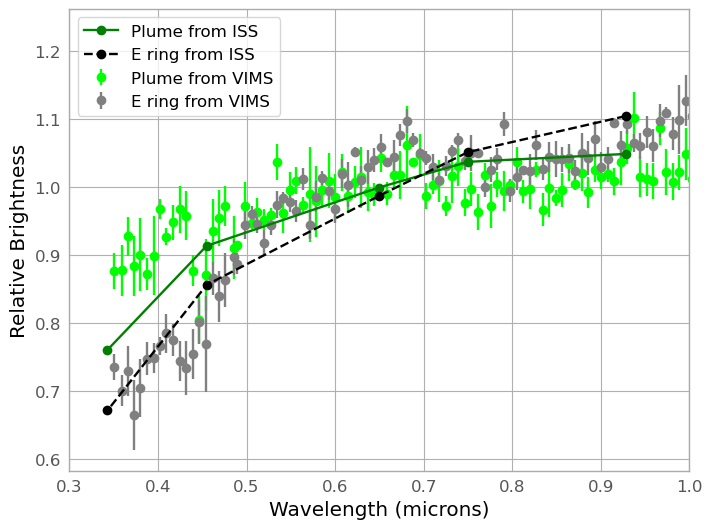

In [5]:
f=open('PlumeSpec_S16_revised_072525.csv','r')
wavew=[]
specobs=[]
errobs=[]
for line in f:
        line = line.strip()
        columns = line.split(',')
        wavew.append(float(columns[0]))
        specobs.append(float(columns[1]))
        errobs.append(float(columns[2]))
wavew=np.array(wavew)
specobs=np.array(specobs)
errobs=np.array(errobs)
plt.errorbar(wavew,specobs,yerr=errobs, fmt='o', color='lime', label='Plume from VIMS')

f=open('EringSpec_S16_revised 072525.csv','r')
wavew=[]
specobs=[]
errobs=[]
for line in f:
        line = line.strip()
        columns = line.split(',')
        wavew.append(float(columns[0]))
        specobs.append(float(columns[1]))
        errobs.append(float(columns[2]))
wavew=np.array(wavew)
specobs=np.array(specobs)
errobs=np.array(errobs)
plt.errorbar(wavew,specobs,yerr=errobs, fmt='o', color='gray', label='E ring from VIMS')

foo=np.abs(xx)<150
specy=np.zeros([5])
for i in range(5):
    specy[i]=np.nanmean(profxy[i,foo])
foo=(np.abs(xx)>200) & (np.abs(xx)<400)
specye=np.zeros([5])
for i in range(5):
    specye[i]=np.nanmean(profy[i,foo])
foox=(waves>400)
plt.plot(waves/1000.,specy/np.mean(specy[foox]), 'o-', color='g', zorder=10, label='Plume from ISS')
plt.plot(waves/1000.,specye/np.mean(specye[foox]), 'o--', color='k',zorder=10, label='E ring from ISS')
plt.legend()
plt.ylabel('Relative Brightness')
plt.xlabel('Wavelength (microns)')
plt.xlim([0.3,1.0])
plt.show()

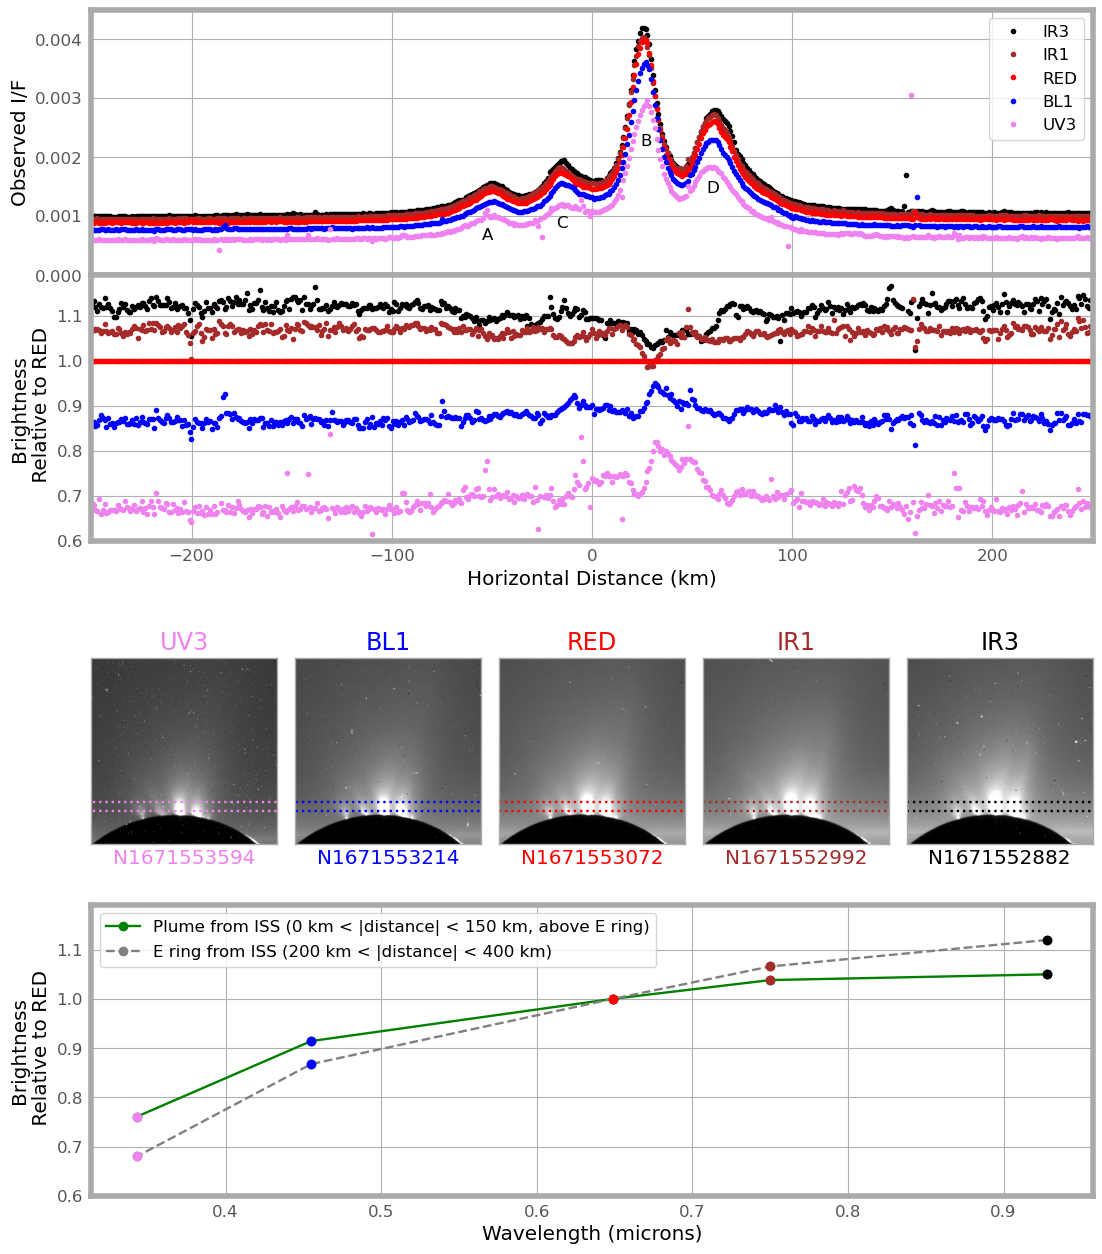

In [7]:
vimax=0.002
vimin=-.000
x=[4,3,2,1,0]
ratmax=1.1
ratmin=0.5

imxy=imx-imx
for i in range(5):
    imxy[i,:,:]=imx[i,:,:]-np.median(imx[i,980:1020,500:600])
    #imxy[i,:,:]=imx[i,:,:]-np.median(imx[i,:,0:200])
imxy=imxy[:,650:1050,350:750]

fig=plt.figure(figsize=(12,12))
(topfig, midfig, bottomfig) = fig.subfigures(3, height_ratios=(2,1,1))
gs = topfig.add_gridspec(2, hspace=0)
top_axs = gs.subplots(sharex=True)
bottom_axs = bottomfig.subplots(1,1)
mid_axs = midfig.subplots(1,5)
#bottom_axs = bottomfig.subplots(2, 1)
for axis in ['top','bottom','left','right']:
        bottom_axs.spines[axis].set_linewidth(4)

bottom_axs.plot(waves/1000.,specy/(specy[2]), 'o-', color='green', label='Plume from ISS (0 km < |distance| < 150 km, above E ring)')
bottom_axs.plot(waves/1000.,specye/(specye[2]), 'o--',color='gray',label='E ring from ISS (200 km < |distance| < 400 km)')
for i in range(5):
    bottom_axs.plot(waves[x[i]]/1000.,specy[x[i]]/(specy[2]), 'o', color=colsy[x[i]], zorder=10)
    bottom_axs.plot(waves[x[i]]/1000.,specye[x[i]]/(specye[2]), 'o', color=colsy[x[i]],zorder=10)

bottom_axs.set_ylim([0.6,1.19])
bottom_axs.legend()
bottom_axs.set_xlabel('Wavelength (microns)')
bottom_axs.set_ylabel('Brightness\n Relative to RED')
vimax=0.002
vimin=-.000
x=[4,3,2,1,0]
ratmax=1.1
ratmin=0.5
imxy=imx-imx
for i in range(5):
    imxy[i,:,:]=imx[i,:,:]-np.median(imx[i,1000:1020,500:600])
    #imxy[i,:,:]=imx[i,:,:]-np.median(imx[i,:,0:200])
#imxy=imxy[:,650:1050,350:750]
for i in range(5):
    mid_axs[i].imshow((imxy[x[i],:,:]), vmin=vimin,vmax=vimax, cmap='gray')
    mid_axs[i].set_xlim([350,750])
    mid_axs[i].set_ylim([1050,650])
    mid_axs[i].plot([0,1000],[960,960],':', color=colsy[x[i]])
    mid_axs[i].plot([0,1000],[980,980],':', color=colsy[x[i]])
    mid_axs[i].grid(False)
    mid_axs[i].set_xticks([])
    mid_axs[i].set_yticks([])
    filen=files[x[i]]
    mid_axs[i].set_title(filters[x[i]], color=colsy[x[i]])
    mid_axs[i].set_xlabel(filen[0:11], color=colsy[x[i]])
for i in range(2):
    for axis in ['top','bottom','left','right']:
        top_axs[i].spines[axis].set_linewidth(4)
for i in range(5):
    top_axs[0].plot(xx,profy[i,:], '.', color=colsy[i], label=filtsy[i])
top_axs[0].text(-55,0.0006,'A', size=12)
top_axs[0].text(-18,0.0008,'C', size=12)
top_axs[0].text(24,0.0022,'B', size=12)
top_axs[0].text(57,0.0014,'D',size=12)
top_axs[0].legend()
top_axs[0].set_ylim([-.000,.0045])
top_axs[0].set_xlim([-400,400])
top_axs[0].set_ylabel('Observed I/F')
for i in range(5):
    top_axs[1].plot(xx,profy[i,:]/profy[2,:], '.', color=colsy[i], label=filtsy[i])
top_axs[1].set_ylim([0.6,1.19])
top_axs[1].set_xlim([-250,250])
top_axs[1].set_ylabel('Brightness\n Relative to RED')
#plt.xlim([-100,100])
top_axs[1].set_xlabel('Horizontal Distance (km)')
fig.tight_layout()
topfig.subplots_adjust(bottom=.1)
#midfig.subplots_adjust(left=0.05, right=1)
#fig.subplots_adjust(right=0.9)
plt.savefig('enc142imdisp_comp_080425.pdf', bbox_inches='tight')
plt.show()